# AWS ReSKILL - AWS AI SERVICES by VIVEK RAJA P S

## Amazon Rekognition

### 1. Detect Labels

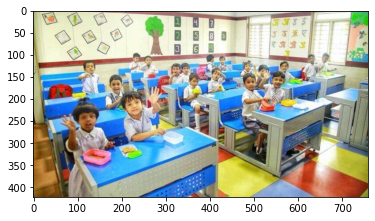

Detected labels in Rekognition/detectable/classroom.jpg
Person : 99.486083984375
Human : 99.486083984375
School : 95.5205307006836
Kindergarten : 91.84310150146484
Classroom : 87.98933410644531
Indoors : 87.98933410644531
Room : 87.98933410644531
Labels detected: 7


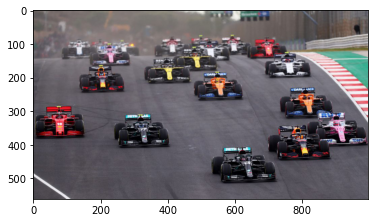

Detected labels in Rekognition/detectable/car.jpg
Car : 98.66287994384766
Automobile : 98.66287994384766
Vehicle : 98.66287994384766
Transportation : 98.66287994384766
Formula One : 98.29401397705078
Driving : 57.31377029418945
Labels detected: 6


In [7]:
import boto3
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def detect_labels_local_file(photo):

    img = mpimg.imread(photo)
    imgplot = plt.imshow(img)
    plt.show()

    client=boto3.client('rekognition')
   
    with open(photo, 'rb') as image:
        response = client.detect_labels(Image={'Bytes': image.read()})
        
    print('Detected labels in ' + photo)    
    for label in response['Labels']:
        print (label['Name'] + ' : ' + str(label['Confidence']))

    return len(response['Labels'])

def main():
    photo1 ='Rekognition/detectable/classroom.jpg'
    photo2 ='Rekognition/detectable/car.jpg'
    
    label_count=detect_labels_local_file(photo1)
    print("Labels detected: " + str(label_count))

    label_count=detect_labels_local_file(photo2)
    print("Labels detected: " + str(label_count))

if __name__ == "__main__":
    main()


### 2. Detect Faces

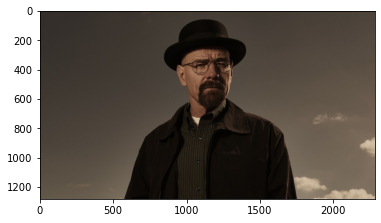

Detected faces for Rekognition/face/heisenberg.jpg
The detected face is between 38 and 56 years old
Here are the other attributes:
{
    "AgeRange": {
        "High": 56,
        "Low": 38
    },
    "Beard": {
        "Confidence": 73.35742950439453,
        "Value": true
    },
    "BoundingBox": {
        "Height": 0.33542972803115845,
        "Left": 0.43076127767562866,
        "Top": 0.16724362969398499,
        "Width": 0.13856694102287292
    },
    "Confidence": 99.99942779541016,
    "Emotions": [
        {
            "Confidence": 65.49198913574219,
            "Type": "SAD"
        },
        {
            "Confidence": 27.9515438079834,
            "Type": "CALM"
        },
        {
            "Confidence": 5.408564567565918,
            "Type": "CONFUSED"
        },
        {
            "Confidence": 0.4087052643299103,
            "Type": "ANGRY"
        },
        {
            "Confidence": 0.28707000613212585,
            "Type": "FEAR"
        },
        {
      

In [12]:
import json
def detect_faces(photo):

    client=boto3.client('rekognition')
    
    img = mpimg.imread(photo)
    imgplot = plt.imshow(img)
    plt.show()

    with open(photo, 'rb') as image:
        response = client.detect_faces(Image={'Bytes': image.read()},Attributes=['ALL'])

    print('Detected faces for ' + photo)    
    for faceDetail in response['FaceDetails']:
        print('The detected face is between ' + str(faceDetail['AgeRange']['Low']) 
              + ' and ' + str(faceDetail['AgeRange']['High']) + ' years old')
        print('Here are the other attributes:')
        print(json.dumps(faceDetail, indent=4, sort_keys=True))
    return len(response['FaceDetails'])
def main():
    
    photo1 ='Rekognition/face/heisenberg.jpg'

    
    face_count=detect_faces(photo1)
    print("Faces detected: " + str(face_count))
    
   


if __name__ == "__main__":
    main()

### 3.  PPE Detection

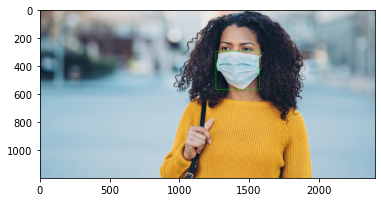

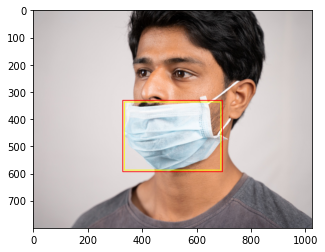

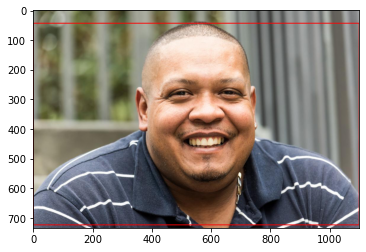

In [17]:
import boto3
import io
from PIL import Image, ImageDraw, ExifTags, ImageColor

def detect_ppe(photo, confidence):

    fill_green='#00d400'
    fill_red='#ff0000'
    fill_yellow='#ffff00'
    line_width=3

    #open image and get image data from stream.
    image = Image.open(open(photo,'rb'))
    stream = io.BytesIO()
    image.save(stream, format=image.format)    
    image_binary = stream.getvalue()
    imgWidth, imgHeight = image.size  
    draw = ImageDraw.Draw(image)  

    client=boto3.client('rekognition')

    response = client.detect_protective_equipment(Image={'Bytes': image_binary})

    for person in response['Persons']:
        
        found_mask=False

        for body_part in person['BodyParts']:
            ppe_items = body_part['EquipmentDetections']
                 
            for ppe_item in ppe_items:
                #found a mask 
                if ppe_item['Type'] == 'FACE_COVER':
                    fill_color=fill_green
                    found_mask=True
                    # check if mask covers face
                    if ppe_item['CoversBodyPart']['Value'] == False:
                        fill_color=fill='#ff0000'
                    # draw bounding box around mask
                    box = ppe_item['BoundingBox']
                    left = imgWidth * box['Left']
                    top = imgHeight * box['Top']
                    width = imgWidth * box['Width']
                    height = imgHeight * box['Height']
                    points = (
                            (left,top),
                            (left + width, top),
                            (left + width, top + height),
                            (left , top + height),
                            (left, top)
                        )
                    draw.line(points, fill=fill_color, width=line_width)

                     # Check if confidence is lower than supplied value       
                    if ppe_item['CoversBodyPart']['Confidence'] < confidence:
                        #draw warning yellow bounding box within face mask bounding box
                        offset=line_width+ line_width 
                        points = (
                                    (left+offset,top + offset),
                                    (left + width-offset, top+offset),
                                    ((left) + (width-offset), (top-offset) + (height)),
                                    (left+ offset , (top) + (height -offset)),
                                    (left + offset, top + offset)
                                )
                        draw.line(points, fill=fill_yellow, width=line_width)
                
        if found_mask==False:
            # no face mask found so draw red bounding box around body
            box = person['BoundingBox']
            left = imgWidth * box['Left']
            top = imgHeight * box['Top']
            width = imgWidth * box['Width']
            height = imgHeight * box['Height']
            points = (
                (left,top),
                (left + width, top),
                (left + width, top + height),
                (left , top + height),
                (left, top)
                )
            draw.line(points, fill=fill_red, width=line_width)

    imgplot = plt.imshow(image)
    plt.show()

def main():
    photo1 ='Rekognition/ppe/mask.jpg'
    photo2 ='Rekognition/ppe/mask1.jpg'
    photo3 ='Rekognition/ppe/mask2.jpg'
    confidence=80
    detect_ppe(photo1, confidence)
    detect_ppe(photo2, confidence)
    detect_ppe(photo3, confidence)

if __name__ == "__main__":
    main()

### 4. Celebrity Recognition

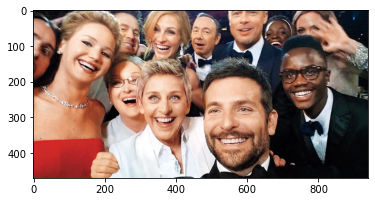

Detected faces for Rekognition/celebrity/moviestars.jpg
Name: Bradley Cooper
Info
   www.imdb.com/name/nm0177896
Name: Jennifer Lawrence
Info
   www.imdb.com/name/nm2225369
Name: Ellen DeGeneres
Info
   www.imdb.com/name/nm0001122
Name: Wayne Wonder
Info
   www.imdb.com/name/nm0938872
Name: Julia Roberts
Info
   www.imdb.com/name/nm0000210
Name: Kevin Spacey
Info
   www.imdb.com/name/nm0000228
Celebrities detected: 6


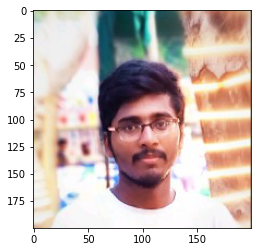

Detected faces for Rekognition/celebrity/me.jpg
Celebrities detected: 0


In [21]:
import boto3
import json

def recognize_celebrities(photo):

    
    client=boto3.client('rekognition')
    img = mpimg.imread(photo)
    imgplot = plt.imshow(img)
    plt.show()
    with open(photo, 'rb') as image:
        response = client.recognize_celebrities(Image={'Bytes': image.read()})

    print('Detected faces for ' + photo)    
    for celebrity in response['CelebrityFaces']:
        print ('Name: ' + celebrity['Name'])
        print ('Info')
        for url in celebrity['Urls']:
            print ('   ' + url)
        print
    return len(response['CelebrityFaces'])

def main():
    photo1='Rekognition/celebrity/moviestars.jpg'

    celeb_count=recognize_celebrities(photo1)
    print("Celebrities detected: " + str(celeb_count))
    
    photo2='Rekognition/celebrity/me.jpg'

    celeb_count=recognize_celebrities(photo2)
    print("Celebrities detected: " + str(celeb_count))


if __name__ == "__main__":
    main()

### 5. Text Detection

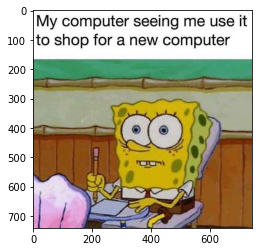

Detected text
----------
Detected text:My computer seeing me use it
Confidence: 99.50%
Detected text:to
Confidence: 99.88%
Detected text:shop a new computer
Confidence: 99.55%
Detected text:for
Confidence: 99.98%
Detected text:My
Confidence: 99.86%
Detected text:computer
Confidence: 99.95%
Detected text:seeing
Confidence: 99.98%
Detected text:me
Confidence: 99.95%
Detected text:use
Confidence: 99.86%
Detected text:it
Confidence: 97.40%
Detected text:to
Confidence: 99.88%
Detected text:shop
Confidence: 99.85%
Detected text:for
Confidence: 99.98%
Detected text:a
Confidence: 98.52%
Detected text:new
Confidence: 99.89%
Detected text:computer
Confidence: 99.93%
Text detected: 16


In [24]:
import boto3

def detect_text(photo):

    client=boto3.client('rekognition')
    img = mpimg.imread(photo)
    imgplot = plt.imshow(img)
    plt.show()
    with open(photo, 'rb') as image:
        response=client.detect_text(Image={'Bytes': image.read()})
                        
    textDetections=response['TextDetections']
    print ('Detected text\n----------')
    for text in textDetections:
            print ('Detected text:' + text['DetectedText'])
            print ('Confidence: ' + "{:.2f}".format(text['Confidence']) + "%")
    return len(textDetections)

def main():

    photo='Rekognition/text/meme.jpg'
    text_count=detect_text(photo)
    print("Text detected: " + str(text_count))


if __name__ == "__main__":
    main()

## Amazon Comprehend

### 1. Detecting Dominant Language

In [28]:
import boto3
import json

comprehend = boto3.client(service_name='comprehend', region_name='us-east-1')
text = "It is raining today in Madurai"

print('Calling DetectEntities')
print(json.dumps(comprehend.detect_entities(Text=text, LanguageCode='en'), sort_keys=True, indent=4))
print('End of DetectEntities\n')

Calling DetectEntities
{
    "Entities": [
        {
            "BeginOffset": 14,
            "EndOffset": 19,
            "Score": 0.9925345182418823,
            "Text": "today",
            "Type": "DATE"
        },
        {
            "BeginOffset": 23,
            "EndOffset": 30,
            "Score": 0.9988563060760498,
            "Text": "Seattle",
            "Type": "LOCATION"
        }
    ],
    "ResponseMetadata": {
        "HTTPHeaders": {
            "content-length": "200",
            "content-type": "application/x-amz-json-1.1",
            "date": "Sun, 25 Apr 2021 16:42:43 GMT",
            "x-amzn-requestid": "ddcf7d9b-4d34-4a2c-b81d-95c09b762d05"
        },
        "HTTPStatusCode": 200,
        "RequestId": "ddcf7d9b-4d34-4a2c-b81d-95c09b762d05",
        "RetryAttempts": 0
    }
}
End of DetectEntities



### 2. Detect Sentiment

In [30]:
import boto3
import json

comprehend = boto3.client(service_name='comprehend', region_name='us-east-1')
                
text = "I am feeling very happy to present today's reskill session!"

print('Calling DetectSentiment')
print(json.dumps(comprehend.detect_sentiment(Text=text, LanguageCode='en'), sort_keys=True, indent=4))
print('End of DetectSentiment\n')

Calling DetectSentiment
{
    "ResponseMetadata": {
        "HTTPHeaders": {
            "content-length": "164",
            "content-type": "application/x-amz-json-1.1",
            "date": "Sun, 25 Apr 2021 16:44:32 GMT",
            "x-amzn-requestid": "32dd922a-c0bb-490f-ae9b-1e520b4f1a2d"
        },
        "HTTPStatusCode": 200,
        "RequestId": "32dd922a-c0bb-490f-ae9b-1e520b4f1a2d",
        "RetryAttempts": 0
    },
    "Sentiment": "POSITIVE",
    "SentimentScore": {
        "Mixed": 0.07154785841703415,
        "Negative": 0.013060450553894043,
        "Neutral": 0.013014402240514755,
        "Positive": 0.9023772478103638
    }
}
End of DetectSentiment



In [31]:
text = "The number of coronavirus cases is increasing at an alarming rate!"

print('Calling DetectSentiment')
print(json.dumps(comprehend.detect_sentiment(Text=text, LanguageCode='en'), sort_keys=True, indent=4))
print('End of DetectSentiment\n')

Calling DetectSentiment
{
    "ResponseMetadata": {
        "HTTPHeaders": {
            "content-length": "161",
            "content-type": "application/x-amz-json-1.1",
            "date": "Sun, 25 Apr 2021 16:45:15 GMT",
            "x-amzn-requestid": "5dfecf43-8e94-46c1-9ece-13c39b17d216"
        },
        "HTTPStatusCode": 200,
        "RequestId": "5dfecf43-8e94-46c1-9ece-13c39b17d216",
        "RetryAttempts": 0
    },
    "Sentiment": "NEUTRAL",
    "SentimentScore": {
        "Mixed": 0.06438537687063217,
        "Negative": 0.31746089458465576,
        "Neutral": 0.5186896324157715,
        "Positive": 0.09946412593126297
    }
}
End of DetectSentiment



In [33]:
text = "I hate to see CSK losing in IPL matches"

print('Calling DetectSentiment')
print(json.dumps(comprehend.detect_sentiment(Text=text, LanguageCode='en'), sort_keys=True, indent=4))
print('End of DetectSentiment\n')

Calling DetectSentiment
{
    "ResponseMetadata": {
        "HTTPHeaders": {
            "content-length": "163",
            "content-type": "application/x-amz-json-1.1",
            "date": "Sun, 25 Apr 2021 16:46:31 GMT",
            "x-amzn-requestid": "6b0b7e91-9086-4c4a-87f0-4e8a9d3b15d6"
        },
        "HTTPStatusCode": 200,
        "RequestId": "6b0b7e91-9086-4c4a-87f0-4e8a9d3b15d6",
        "RetryAttempts": 0
    },
    "Sentiment": "NEGATIVE",
    "SentimentScore": {
        "Mixed": 0.000761170347686857,
        "Negative": 0.8971641063690186,
        "Neutral": 0.09938450902700424,
        "Positive": 0.002690250054001808
    }
}
End of DetectSentiment

